In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import time

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import battleship_utils_py as bscpp
import battleship_board_rbt as bsrbt

# Device configuration
device = torch.device('cpu') #cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# Generate some quick occupancy input data for some reasonable-looking battleship arrangments
class BoardInfo:
    board_width = 10.
    board_height = 10.
    w_size = 10
    theta_size = 10
    x_cells = 20
    y_cells = 20
    t_cells = 20

board_info = BoardInfo()

data = np.loadtxt("data/uniform_feasible_2d.csv", delimiter=",")

In [3]:
# Define a network to map from 2D occupancy + sampled noise + parameter vector
# to a probability heat map over discretized new object poses

class SceneFeatureExtractor(nn.Module):
    def __init__(self, board_info):
        super(SceneFeatureExtractor, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=4, 
                      kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

class ContinueHead(nn.Module):
    def __init__(self, board_info):
        super(ContinueHead, self).__init__()
        self.decision_layer = nn.Sequential(
            nn.Linear(200 + board_info.w_size + board_info.theta_size, 1),
            nn.Sigmoid())

    def forward(self, x, w, theta):
        out = x.reshape(x.size(0), -1)
        out = torch.cat([out, w, theta], -1)
        out = self.decision_layer(out)
        return out

class PlacerHead(nn.Module):
    def __init__(self, board_info):
        super(PlacerHead, self).__init__()
        self.board_info = board_info
        num_state_output_cells = board_info.x_cells * board_info.y_cells * board_info.t_cells
        num_update_output_cells = board_info.x_cells * board_info.y_cells
        self.fc = nn.Sequential(
            nn.Linear(200 + board_info.w_size + board_info.theta_size, num_state_output_cells),
            nn.Sigmoid())
        #self.fc_state_update = nn.Sequential(
        #    nn.Linear(200 + board_info.w_size + board_info.theta_size, num_update_output_cells),
        #    nn.Sigmoid())
        
    def forward(self, x, w, theta):
        inp = torch.cat([x.reshape(x.size(0), -1), w, theta], -1)
        out_state = self.fc(inp).reshape(
            inp.size(0), self.board_info.x_cells, self.board_info.y_cells, self.board_info.t_cells)
        #out_update = self.fc_state_update(inp).reshape(
        #    inp.size(0), 1, self.board_info.x_cells, self.board_info.y_cells)
        return out_state#, out_update

class CustomSequential(nn.Module):
    def __init__(self, l1, l2):
        super(CustomSequential, self).__init__()
        self.l1 = l1
        self.l2 = l2
    def forward(self, x, w, theta):
        outs = self.l1(x)
        return self.l2(outs, w, theta)
    
feature_layer = SceneFeatureExtractor(board_info).to(device)
continue_head = ContinueHead(board_info).to(device)
placer_head = PlacerHead(board_info).to(device)
continue_net = CustomSequential(feature_layer, continue_head).to(device)
placer_net = CustomSequential(feature_layer, placer_head).to(device)

In [4]:
datapoint = torch.zeros((1, 1, 20, 20))
datapoint_ad = torch.autograd.Variable(datapoint, requires_grad=True)
w_ad = torch.autograd.Variable(torch.zeros((1, 10)), requires_grad=True)
theta_ad = torch.autograd.Variable(torch.zeros((1, 10)), requires_grad=True)
continue_net(datapoint_ad, w_ad, theta_ad)
placer_net(datapoint_ad, w_ad, theta_ad);

print placer_net.parameters()
print continue_net.parameters()


<generator object parameters at 0x7f97590f0410>
<generator object parameters at 0x7f97590f0410>


In [250]:
import battleship_board_rbt as bsrbt

# Global context sloppiness
# Also assumes global "board_info" object
premade_rbts = {}

def get_appropriate_rbt(q):
    n_ships = q.shape[0]/3
    if n_ships not in premade_rbts.keys():
        premade_rbts[n_ships], _ = bsrbt.spawn_rbt(
            board_info.board_width, board_info.board_height, 
            max_length=1, N=n_ships, random_length=False)
    return premade_rbts[n_ships]

class ProjectToFeasibility(torch.autograd.Function):
    @staticmethod
    def forward(ctx, q0):
        rbt = get_appropriate_rbt(q0)
        qf, info, dqf_dq0 = bsrbt.projectToFeasibilityWithIK(
            rbt, q0.detach().numpy(), board_info.board_width,
            board_info.board_height)
        ctx.save_for_backward(torch.Tensor(dqf_dq0))
        return torch.autograd.Variable(torch.Tensor(qf))
    
    @staticmethod
    def backward(ctx, grad_output):
        dqf_dq0, = ctx.saved_tensors
        #adding a little help along the diagonal
        #gives the net the intuition that moving
        #the direction it really wants will eventually
        #pull the state off whatever manifold it might
        #be stuck on
        dqf_dq0 = dqf_dq0*1.0 + 0.0 * torch.eye(dqf_dq0.shape[0])
        return torch.mv(dqf_dq0, grad_output)

torch.manual_seed(40)
q0 = torch.autograd.Variable(torch.rand((6, 1)), requires_grad=True)
qf = ProjectToFeasibility.apply(q0)
print "fwd: ", qf

for i in range(6):
    qf[i].backward(retain_graph=True)
    print q0.grad
    q0.grad.zero_()

fwd:  tensor([ 5.0938e-01,  5.0947e-01,  6.7278e-12,  1.4501e+00,  1.2653e+00,
         4.9916e-01])
tensor([ 0.9943,  0.0280,  0.0207, -0.0585, -0.0319, -0.0009])
tensor([ 0.0280,  0.8620, -0.1021,  0.2882,  0.1571,  0.0045])
tensor([ 0.0207, -0.1021,  0.9244,  0.2133,  0.1163,  0.0033])
tensor([-0.0585,  0.2882,  0.2133,  0.3983, -0.3281, -0.0094])
tensor([-0.0319,  0.1571,  0.1163, -0.3281,  0.8211, -0.0051])
tensor([-0.0009,  0.0045,  0.0033, -0.0094, -0.0051,  0.9999])


In [251]:
q0 = torch.autograd.Variable(torch.Tensor([0., 0., 0., 1., 1., 1]), requires_grad=True)
goal_qf = torch.Tensor([1., 1., 0., 1., 1.5, 0.])

optimizer = torch.optim.SGD([q0], lr=0.5)

loss = torch.nn.MSELoss()

pose_history = np.zeros((100, 6))
projected_pose_history = np.zeros((100, 6))

for i in range(100):    
    optimizer.zero_grad()

    # forward
    pose_history[i, :] = q0.detach().numpy()
    qf = ProjectToFeasibility.apply(q0)
    projected_pose_history[i, :] = qf.detach().numpy()
    error = loss(qf, goal_qf)
    
    # backward
    error.backward()
    
    # update
    optimizer.step()
    print ('Step [{}/{}], Loss: {:.4f}' 
        .format(i+1, 100, error.item()))

Bounds violation detected, solution wasn't feasible
0.000000 <= 1.368056 <= 0.000000
Constraint type  <class 'pydrake.solvers._ik_py.MinDistanceConstraint'>
Step [1/100], Loss: 0.2473
Step [2/100], Loss: 0.2216
Step [3/100], Loss: 0.1919
Step [4/100], Loss: 0.1713
Step [5/100], Loss: 0.1024
Step [6/100], Loss: 0.1561
Step [7/100], Loss: 0.0942
Step [8/100], Loss: 0.0861
Step [9/100], Loss: 0.0719
Bounds violation detected, solution wasn't feasible
0.000000 <= 0.322177 <= 0.000000
Constraint type  <class 'pydrake.solvers._ik_py.MinDistanceConstraint'>
Step [10/100], Loss: 0.0629
Step [11/100], Loss: 0.0536
Step [12/100], Loss: 0.0475
Bounds violation detected, solution wasn't feasible
0.000000 <= 0.000379 <= 0.000000
Constraint type  <class 'pydrake.solvers._ik_py.MinDistanceConstraint'>
Step [13/100], Loss: 0.1177
Step [14/100], Loss: 0.0453
Step [15/100], Loss: 0.0426
Bounds violation detected, solution wasn't feasible
0.000000 <= 0.891840 <= 0.000000
Constraint type  <class 'pydrake.

<IPython.core.display.Javascript object>


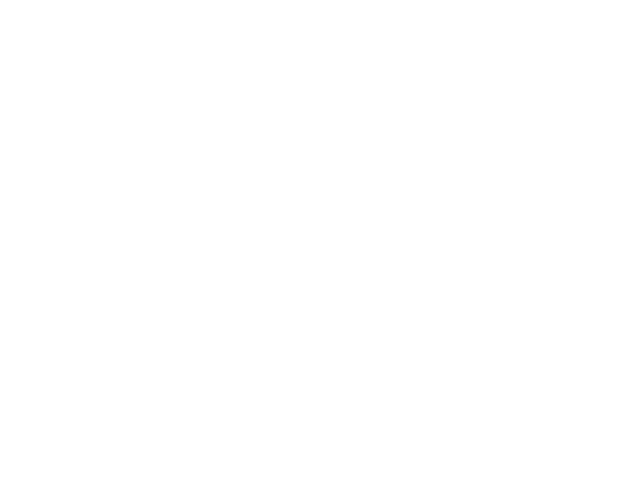

Spawning PlanarRigidBodyVisualizer for tree with 0 actuators
Spawning PlanarRigidBodyVisualizer for tree with 0 actuators


In [252]:
from matplotlib import animation, rc
from IPython.display import HTML

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.close()
Tview = np.array([[1., 0., 0., 0.],
                      [0., 1., 0., 0.],
                      [0., 0., 0., 0.],
                      [0., 0., 0., 1.]])
viz1 = bsrbt.BattleshipBoardVisualizer(
        int(board_info.board_width), int(board_info.board_height), 
        get_appropriate_rbt(pose_history[0]), Tview, 
        xlim=[0., board_info.board_width],
        ylim=[0., board_info.board_height], ax=ax1)
viz2 = bsrbt.BattleshipBoardVisualizer(
        int(board_info.board_width), int(board_info.board_height), 
        get_appropriate_rbt(pose_history[0]), Tview, 
        xlim=[0., board_info.board_width],
        ylim=[0., board_info.board_height], ax=ax2)

def animate(i):
    viz1.draw(pose_history[i])
    viz2.draw(projected_pose_history[i])
    
anim = animation.FuncAnimation(fig, animate,
                               frames=len(pose_history), interval=20)
HTML(anim.to_html5_video())

In [34]:
class FrontEnd(nn.Module):
  ''' front end part of discriminator and Q'''
    def __init__(self):
        super(FrontEnd, self).__init__()
        self.main = nn.Sequential(
          nn.Conv2d(1, 64, 4, 2, 1),
          nn.LeakyReLU(0.1, inplace=True),
          nn.Conv2d(64, 128, 4, 2, 1, bias=False),
          nn.BatchNorm2d(128),
          nn.LeakyReLU(0.1, inplace=True),
          nn.Conv2d(128, 1024, 7, bias=False),
          nn.BatchNorm2d(1024),
          nn.LeakyReLU(0.1, inplace=True),
        )
    def forward(self, x):
        output = self.main(x)
        return output

# Discriminator with its Q-head
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
          nn.Conv2d(1024, 1, 1),
          nn.Sigmoid()
        )
    def forward(self, x):
        output = self.main(x).view(-1, 1)
        return output

class Q(nn.Module):
    def __init__(self):
        super(Q, self).__init__()
        self.conv = nn.Conv2d(1024, 128, 1, bias=False)
        self.bn = nn.BatchNorm2d(128)
        self.lReLU = nn.LeakyReLU(0.1, inplace=True)
        self.conv_mu = nn.Conv2d(128, 2, 1)
        self.conv_var = nn.Conv2d(128, 2, 1)

    def forward(self, x):
        y = self.conv(x)
        mu = self.conv_mu(y).squeeze()
        var = self.conv_var(y).squeeze().exp()
        return disc_logits, mu, var 


<IPython.core.display.Javascript object>


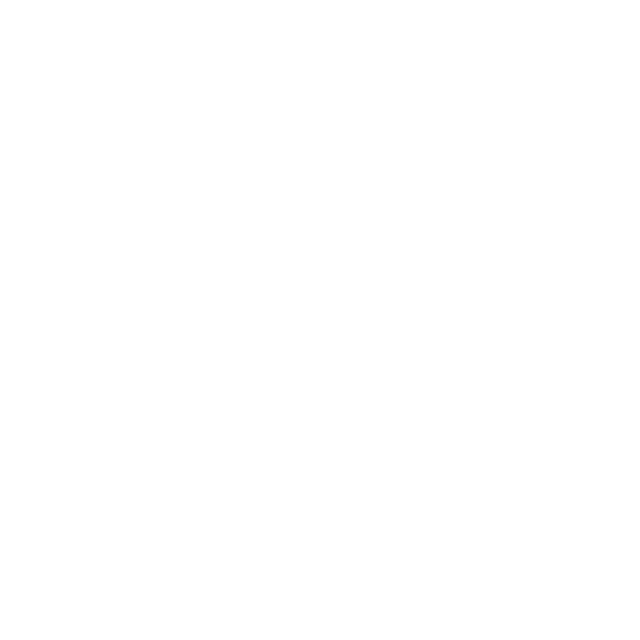

torch.Size([900000, 6])
torch.Size([6])
Spawning PlanarRigidBodyVisualizer for tree with 0 actuators
<class 'torch.Tensor'> tensor(15.0041)


RuntimeError: tensors used as indices must be long or byte tensors

In [71]:
optimizer = torch.optim.Adam(torch.nn.ModuleList([placer_net,continue_net]).parameters(), lr=0.01)
n_train = int(data.shape[0]*0.9)
n_epochs = 10

train_data = torch.utils.data.TensorDataset(
    torch.unsqueeze(torch.Tensor(data[0:n_train, :]), 0))
test_data = torch.utils.data.TensorDataset(
    torch.unsqueeze(torch.Tensor(data[n_train:, :]), 0))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1,
                        shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,
                        shuffle=True, num_workers=4)

fig, (ax1, ax2) = plt.subplots(1, 2)

def draw_state(q):
    rbt = get_appropriate_rbt(q)
    bsrbt.draw_board_state(ax1, rbt, q, 
                           int(board_info.board_width),
                           int(board_info.board_height))
    time.sleep(1E-6)
def project_to_feasibility(q):
    qf = ProjectToFeasibility.apply(q)
    return qf
def populate_occupancy(q):
    new_grid = torch.zeros([board_info.x_cells, board_info.y_cells])
    x_step = board_info.board_width / board_info.x_cells
    y_step = board_info.board_height / board_info.y_cells
    for i in range(q.shape[0]/3):
        xi = (q[i*3+0]/x_step)
        yi = (q[i*3+0]/y_step)
        print type(xi), yi
        new_grid[xi, yi] = 1.
    return new_grid
    
for epoch in range(n_epochs):
    for i, databatch in enumerate(train_loader):
        databatch = databatch[0][0].to(device)
        
        # Forward pass, which must unfortunately
        # be done elementwise
        
        print databatch.shape
        for datapt in databatch:
            print datapt.shape
            ### FORWARD PASS
            board_occupancy = torch.autograd.Variable(
                torch.zeros((1, 1, board_info.x_cells , 
                             board_info.y_cells)),
                requires_grad=True)
            q = torch.empty((0))
            # SAMPLE PARAMS
            theta = torch.autograd.Variable(torch.rand((1, 10)), requires_grad=True)
            w = torch.autograd.Variable(torch.randn((1, 10)), requires_grad=False)
            while continue_net(board_occupancy, w, theta) >= torch.rand((1, 1)) - 0.3:
                w = torch.autograd.Variable(torch.randn((1, 10)), requires_grad=False)
                out = placer_net(board_occupancy, w, theta)
                placement_map = out[0, 0:3, :, :]
                reduce_x, reduce_x_ind = torch.max(placement_map, 0)
                reduce_y, reduce_y_ind = torch.max(reduce_x, 0)
                reduce_t, reduce_t_ind = torch.max(reduce_y, 0)
                reduce_y_ind = reduce_y_ind[reduce_t_ind]
                reduce_x_ind = reduce_x_ind[reduce_y_ind, reduce_t_ind]
                new_x = reduce_x_ind / float(board_info.x_cells) * board_info.board_width
                new_y = reduce_y_ind / float(board_info.y_cells) * board_info.board_height
                new_t = reduce_t_ind / float(board_info.t_cells) * 2. *np.pi
                
                q = np.hstack([q, np.array([new_x, new_y, new_t])])
                #board_occupancy += torch.unsqueeze(torch.unsqueeze(populate_occupancy(q), 0), 0)

            draw_state(q)
            #ax2.imshow(board_occupancy[0, 0, :, :])
            fig.canvas.draw()
            time.sleep(1E-6)
            
            loss = torch.nn.MSELoss()
            
            error = loss(board_occupancy[0, 0, : ,:], populate_occupancy(datapt))
            # Run a few gradient descent steps to find the optimal 
            optimizer = torch.optim.Adam([theta], lr=0.01)
            optimizer.zero_grad()
            print error
            error.backward()
            for k in range(10):
                optimizer.step()
                print ('Step [{}/{}], Loss: {:.4f}' 
                       .format(k+1, 10, error.item()))
            
            
        # Backward and optimize
        optimizer.zero_grad()
        print theta[0, 0]
        theta[0, 0].backward()
        theta[0, 0].backward()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))